#Klasifikasi Bahasa Isyarat Menggunakan Model Deep Learning

## Proyek ini bertujuan untuk mengembangkan model klasifikasi gambar yang mampu mengenali alfabet bahasa isyarat dari gambar. Model menggunakan arsitektur MobileNet yang telah dilatih sebelumnya untuk ekstraksi fitur dan dilengkapi dengan lapisan Dense untuk klasifikasi.

#  Memuat dan Mengekstrak Dataset
Dataset diunduh dari Kaggle menggunakan token API. Dataset kemudian diekstraksi ke direktori lokal.


In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp 'kaggle.json' ~/.kaggle
!chmod 600 ~/.kaggle/'kaggle.json'
!kaggle datasets download -d 'danrasband/asl-alphabet-test'

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/danrasband/asl-alphabet-test
License(s): CC0-1.0
 78% 19.0M/24.3M [00:00<00:00, 33.5MB/s]
100% 24.3M/24.3M [00:00<00:00, 42.2MB/s]


# Import Library yang di perlukan




*   cv2: OpenCV digunakan untuk operasi pemrosesan gambar.

*   numpy: Numpy digunakan untuk operasi array dan manipulasi data.

*   pandas: Pandas digunakan untuk manipulasi data dan analisis.

*   matplotlib.pyplot: Matplotlib digunakan untuk visualisasi data.
*   zipfile: Zipfile digunakan untuk ekstraksi file dari arsip zip.


*   Path dan os.path: Digunakan untuk operasi path file.


*   tensorflow: TensorFlow adalah pustaka untuk pembelajaran mesin dan deep learning.


*   image, MobileNet, Dense, ImageDataGenerator dari tensorflow.keras: Digunakan untuk memuat, memproses, dan membangun model jaringan saraf.







In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from pathlib import Path
import os.path

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extracing data set
Ekstraksi file dari arsip zip menggunakan modul zipfile. Dalam proyek ini, dataset berupa file zip

In [3]:
dataset = zipfile.ZipFile('asl-alphabet-test.zip')
dataset.extractall()
dataset.close()

#  Mengumpulkan Jalur File dan Label
* Fungsi get_paths_labels
Fungsi ini digunakan untuk mendapatkan jalur file gambar dan labelnya dari direktori yang diberikan.
* Fungsi get_image Fungsi ini digunakan untuk membaca dan memproses gambar.
* Fungsi visualize_samples Fungsi ini digunakan untuk memvisualisasikan sampel gambar dari ImageDataGenerator
* Fungsi process Fungsi ini digunakan untuk memproses gambar sebelum dimasukkan ke dalam model.









In [4]:
# Ubah folder menjadi kerangka data jalur & label gambar
def get_paths_labels(path, allowed_extension="jpg"):
        global Path
        images_dir = Path(path)

        filepaths = pd.Series((images_dir.glob(fr'**/*.{allowed_extension}'))).astype(str)
        filepaths.name = "path"

        labels = filepaths.str.split("/")[:].str[-2]
        labels.name = "label"
# Menggabungkan jalur file dan label
        df = pd.concat([filepaths, labels], axis=1)

        # Shuffle the DataFrame and reset index
        df = df.sample(frac=1).reset_index(drop = True)
        return df

        # untuk baca image
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

    # Untuk visualisai sampel data
def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)

    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    images = filepaths.apply(get_image).reset_index(drop=True)

    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()

    # untuk Process gambar model
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

# Buat klasifikasi & visualisasikan hasilnya
def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)

    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]

    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])

    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_true = labels

    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)

    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"Y true({y_true[sample_index]}) | Y pred ({y_pred[sample_index]})")
            ax[i,j].set_axis_off()
    plt.show()


# Membuat DataFrame untuk Jalur dan Label Gambar
* memanggil fungsi get_paths_labels dua kali untuk membuat dua DataFrame terpisah dari direktori yang sama (/content/asl-alphabet-test).
*  menggabungkan kedua DataFrame menggunakan pd.concat.




In [5]:
train_df = get_paths_labels('/content/asl-alphabet-test')

temp_df = get_paths_labels('/content/asl-alphabet-test')

dataset = pd.concat((train_df, temp_df))

## menghitung jumlah sampel dalam setiap kelas dalam dataset, serta menampilkan total ukuran dataset

In [6]:
# Classes counts
print("Classes counts")
counts = dataset.iloc[:,1].value_counts().sort_index()
print(counts.head(counts.shape[0]))
print(f"\n\nDataset size = {counts.sum()} samples")

Classes counts
label
A          60
B          60
C          60
D          60
E          60
F          60
G          60
H          60
I          60
J          60
K          60
L          60
M          60
N          60
O          60
P          60
Q          60
R          60
S          60
T          60
U          60
V          60
W          60
X          60
Y          60
Z          60
del        60
nothing    60
space      60
Name: count, dtype: int64


Dataset size = 1740 samples


#  membuat generator gambar yang akan digunakan untuk melatih dan memvalidasi model menggunakan TensorFlow Keras


*   ImageDataGenerator: Generator ini digunakan untuk membaca gambar dari DataFrame dan menerapkan augmentasi serta preprocessing sebelum gambar diberikan ke model. Ini membantu dalam meningkatkan performa model dengan memperkaya dataset melalui augmentasi.
*   flow_from_dataframe: Metode ini membuat generator yang akan menghasilkan batch gambar dari DataFrame. Ini digunakan untuk memudahkan pengolahan data yang diambil dari jalur file dan label yang disimpan dalam DataFrame.



In [7]:
# Proses data

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    validation_split=0.2,
    horizontal_flip = True,
    brightness_range=(0.75, 1.3),
    zoom_range=0.2
)

train_images = train_generator.flow_from_dataframe(
    dataframe=dataset,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataset,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='validation'
)


Found 1392 validated image filenames belonging to 29 classes.
Found 348 validated image filenames belonging to 29 classes.


# Memanggil fungsi visualize_samples dengan train_images sebagai argumennya akan menampilkan sampel gambar dari generator data pelatihan (train_images).


*   Melihat grid gambar yang diambil dari data pelatihan, yang sudah diacak
*   Telah mengalami augmentasi seperti flip horizontal atau perubahan kecerahan
*   Setiap gambar akan diberi label sesuai dengan kelasnya
*   Ini membantu dalam memverifikasi bahwa data generator bekerja dengan baik dan augmentasi diterapkan dengan benar.



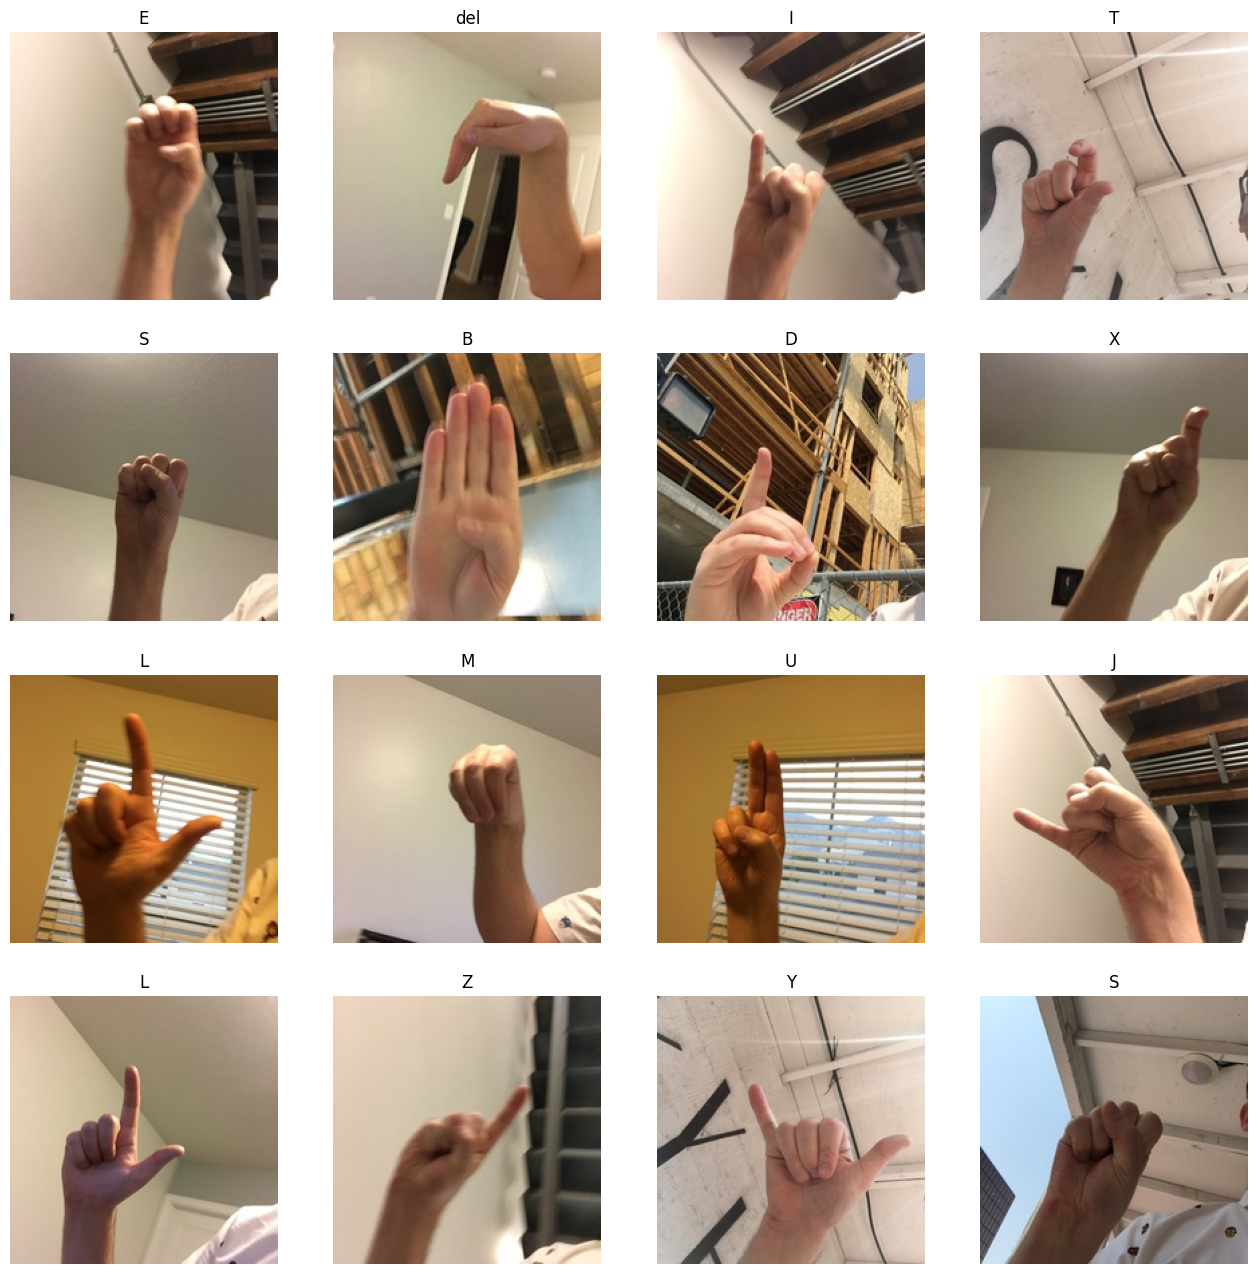

In [8]:
visualize_samples(train_images)

# Create Model

 arsitektur jaringan saraf menggunakan model pra-terlatih MobileNet dan Menambahkan  beberapa lapisan tambahan untuk klasifikasi pada dataset baru

In [9]:
# Arsitektur Neural Network

pretrainedModel = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.001)

17225924/17225924 [==============================] - 0s 0us/step


melakukan kompilasi model Keras, menyiapkannya untuk dilatih
Kompilasi adalah langkah menentukan optimizer, fungsi loss, dan metrik evaluasi yang akan digunakan selama pelatihan

In [10]:
# Compile model
model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

melatih model menggunakan data yang telah dipersiapkan sebelumnya. Metode fit pada model Keras akan melakukan proses pelatihan

In [11]:
# Fit model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
 )

Epoch 1/50
22/22 [==============================] - 128s 6s/step - loss: 3.5289 - accuracy: 0.0467 - val_loss: 3.2626 - val_accuracy: 0.1609
Epoch 2/50
22/22 [==============================] - 115s 5s/step - loss: 3.2660 - accuracy: 0.0790 - val_loss: 3.1003 - val_accuracy: 0.2385
Epoch 3/50
22/22 [==============================] - 116s 5s/step - loss: 3.1294 - accuracy: 0.1185 - val_loss: 2.9153 - val_accuracy: 0.3161
Epoch 4/50
22/22 [==============================] - 113s 5s/step - loss: 2.9708 - accuracy: 0.1652 - val_loss: 2.6612 - val_accuracy: 0.4109
Epoch 5/50
22/22 [==============================] - 114s 5s/step - loss: 2.7427 - accuracy: 0.2162 - val_loss: 2.3204 - val_accuracy: 0.5230
Epoch 6/50
22/22 [==============================] - 119s 5s/step - loss: 2.5226 - accuracy: 0.2565 - val_loss: 2.0378 - val_accuracy: 0.5805
Epoch 7/50
22/22 [==============================] - 133s 6s/step - loss: 2.3000 - accuracy: 0.3305 - val_loss: 1.8413 - val_accuracy: 0.6178
Epoch 8/50
22

# Visualisasi Training dan Validation Loss serta Accuracy
 membuat plot dari hasil pelatihan yang tersimpan dalam objek history. Plot membantu dalam memahami bagaimana model belajar dan bagaimana kinerjanya pada data validasi selama pelatihan.



*   Membuat plot untuk training accuracy (warna merah) dan validation accuracy (warna biru).




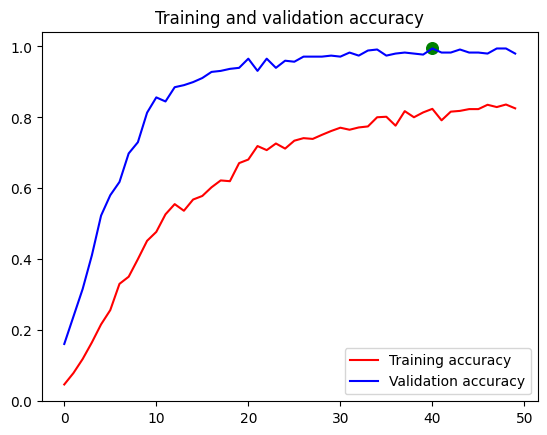

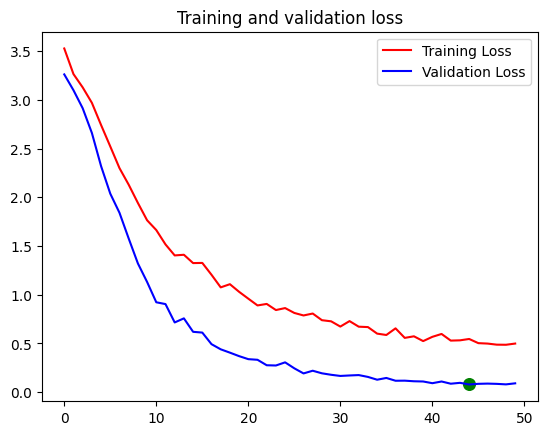

In [12]:
#Visualisai Training & Validation  Loss & Accuracy

%matplotlib inline
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs = np.arange(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.scatter(epochs[val_acc.argmax()], val_acc.max(), color='green', s=70)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.scatter(epochs[val_loss.argmin()], val_loss.min(), color='green', s=70)
plt.title('Training and validation loss')
plt.legend()

plt.show()

* Fungsi visualize_classifications
Fungsi ini akan menampilkan beberapa contoh gambar dari set validasi bersama dengan label asli dan label prediksi dari model.

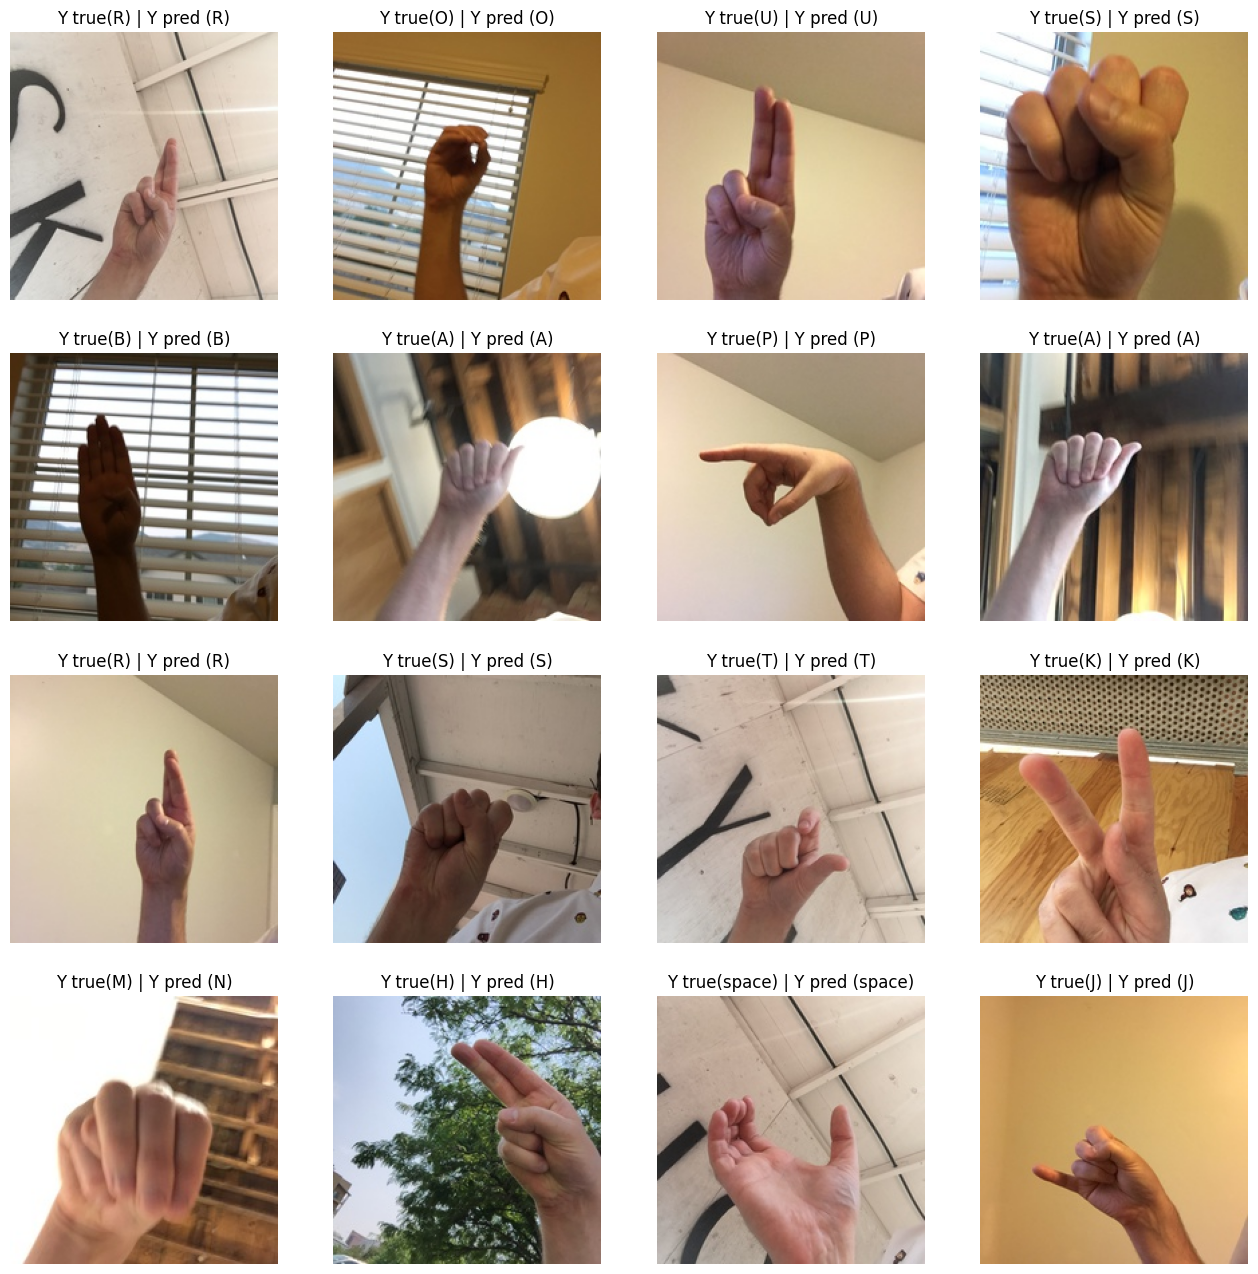

In [13]:
# Visualize classifications on validation set
visualize_classifications(model, val_images)

menyimpan model yang telah dilatih menggunakan TensorFlow/Keras

In [14]:
# Save model
model.save('ASL Classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Uji Prediksi Model

Mendefinisikan Nama Kelas

In [15]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
               'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
               'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del',
               'nothing', 'space']

#Membaca, Memproses, dan Memprediksi Gambar

In [17]:
import cv2
import numpy as np

# Baca dan proses gambar
image_path = '/content/asl-alphabet-test/E/E0002_test.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))

# Normalisasi gambar
image = tf.keras.applications.mobilenet.preprocess_input(image)
image = np.expand_dims(image, axis=0)

# Gunakan model untuk prediksi
predictions = model.predict(image)

# Ubah prediksi menjadi label kelas
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]

print("Deteksi class:", predicted_class)


1/1 [==============================] - 0s 61ms/step
Deteksi class: E
